# Tutorial

In [1]:
# import modules: `pip install defigraph` or `python -m pip install -e .` 
from defigraph.Graph import Graph
from defigraph.Edge import Edge
from defigraph.Vertex import Vertex
from defigraph.Pool import Pool

## 1.0 Get Decentralize Exchange (DEX) token data

In [2]:
# Option 1: Use data from cached results
import json

with open('data.json') as f:
  data = json.load(f)

In [3]:
# Option 2: Use data from API Call
import os
import requests
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("api_key")
base_url = "https://gateway.thegraph.com/api"
# ETH-mainnet 
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV" # Uniswap V3
subgraph_url = f"{base_url}/subgraphs/id/{subgraph_id}"
headers = {
  'Content-Type': 'application/json',
  'Authorization': f'Bearer {api_key}'
}
payload = {"query": "{ pools (orderBy: volumeUSD, orderDirection: desc, first: 5) { token0 { name symbol decimals id } token0Price token1Price token1 { decimals name symbol id } feeTier id } }"} # V3
response = requests.post(subgraph_url, headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
  data = response.json()['data']['pools']
else:
  print("Error:", response.text)

## 1.1 Build Defi Graph

In [4]:
from web3 import Web3
edges = []

for pool in data:
  fee = pool['feeTier']  

  token0 = pool['token0']['symbol']
  token0_decimals = int(pool['token0']['decimals'])
  token0_address = Web3.to_checksum_address(pool['token0']['id'])
  token0Price = float(pool['token0Price'])

  token1 = pool['token1']['symbol']
  token1_decimals = int(pool['token1']['decimals'])
  token1_address = Web3.to_checksum_address(pool['token1']['id'])
  token1Price = float(pool['token1Price'])

  pool_address = Web3.to_checksum_address(pool['id'])

  u = Vertex(token0, token0_decimals, token0_address)
  v = Vertex(token1, token1_decimals, token1_address)

  pool = Pool(pool_address=pool_address, token0=u, token1=v, fee=fee, token0_price=token0Price, token1_price=token1Price)
  pool2 = Pool(pool_address=pool_address, token0=v, token1=u, fee=fee, token0_price=token1Price, token1_price=token0Price)
  edge = Edge(pool=pool)
  edge2 = Edge(pool=pool2)
  edges.append(edge)
  edges.append(edge2)

g = Graph(edges=edges)

In [5]:
print(f"No. of vertices {len(g.vertices)}")
print(f"No. of edges {len(g.get_edges())}")

No. of vertices 4
No. of edges 10


## 2. Bellman-Ford Algorithm

In [6]:

def bellman_ford(graph: Graph, start_vertex: Vertex):
  
  # 1. Initialize distances
  distances = {key: float('inf') for key in graph.vertices}
  predecessor = {key: None for key in graph.vertices}
  distances[start_vertex] = 0

  # 2. Relax edges for n - 1 steps
  for i in range(len(graph.vertices) - 1):
    for edge in g.get_edges():
      (u,v,w) = edge
      if distances[u] + w[0] < distances[v]:
        distances[v] = distances[u] + w[0]
        predecessor[v] = (u, w) 

  # 3. Detect negative cycle
  for edge in g.get_edges():
    (u,v,w) = edge
    if distances[u] + w[0] < distances[v]:
      print("🌟 CYCLE FOUND", w)


  return distances, predecessor
bellman_ford(g, Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")))


🌟 CYCLE FOUND (-7.832425629907495, (USDC, WETH, '500'))
🌟 CYCLE FOUND (0.0009050532828726206, (USDC, USDT, '100'))


({USDC: 7.8291289941894515,
  WETH: -0.002197757145362189,
  USDT: 7.8310044497329905,
  WBTC: -3.2745471883025288},
 {USDC: (WETH, (7.831326751334814, (WETH, USDC, '3000'))),
  WETH: (USDC, (-7.832425629907495, (USDC, WETH, '500'))),
  USDT: (WETH, (7.833202206878353, (WETH, USDT, '500'))),
  WBTC: (WETH, (-3.2723494311571666, (WETH, WBTC, '500')))})

In [7]:
import math
math.e ** -(-7.830020249256383 + 0.0009123075118552688 + 7.826887505027506)

1.0022229037122259

[([USDC, WETH, (-7.832425629907495, (USDC, WETH, '500'))]), ([WETH, USDC, (7.832425629907495, (WETH, USDC, '500'))]), ([WETH, USDT, (7.833202206878353, (WETH, USDT, '500'))]), ([USDT, WETH, (-7.833202206878353, (USDT, WETH, '500'))]), ([USDC, USDT, (0.0009050532828726206, (USDC, USDT, '100'))]), ([USDT, USDC, (-0.0009050532828727188, (USDT, USDC, '100'))]), ([USDC, WETH, (-7.831326751334814, (USDC, WETH, '3000'))]), ([WETH, USDC, (7.831326751334814, (WETH, USDC, '3000'))]), ([WBTC, WETH, (3.2723494311571666, (WBTC, WETH, '500'))]), ([WETH, WBTC, (-3.2723494311571666, (WETH, WBTC, '500'))])]
[USDC, WETH, USDT, WBTC]


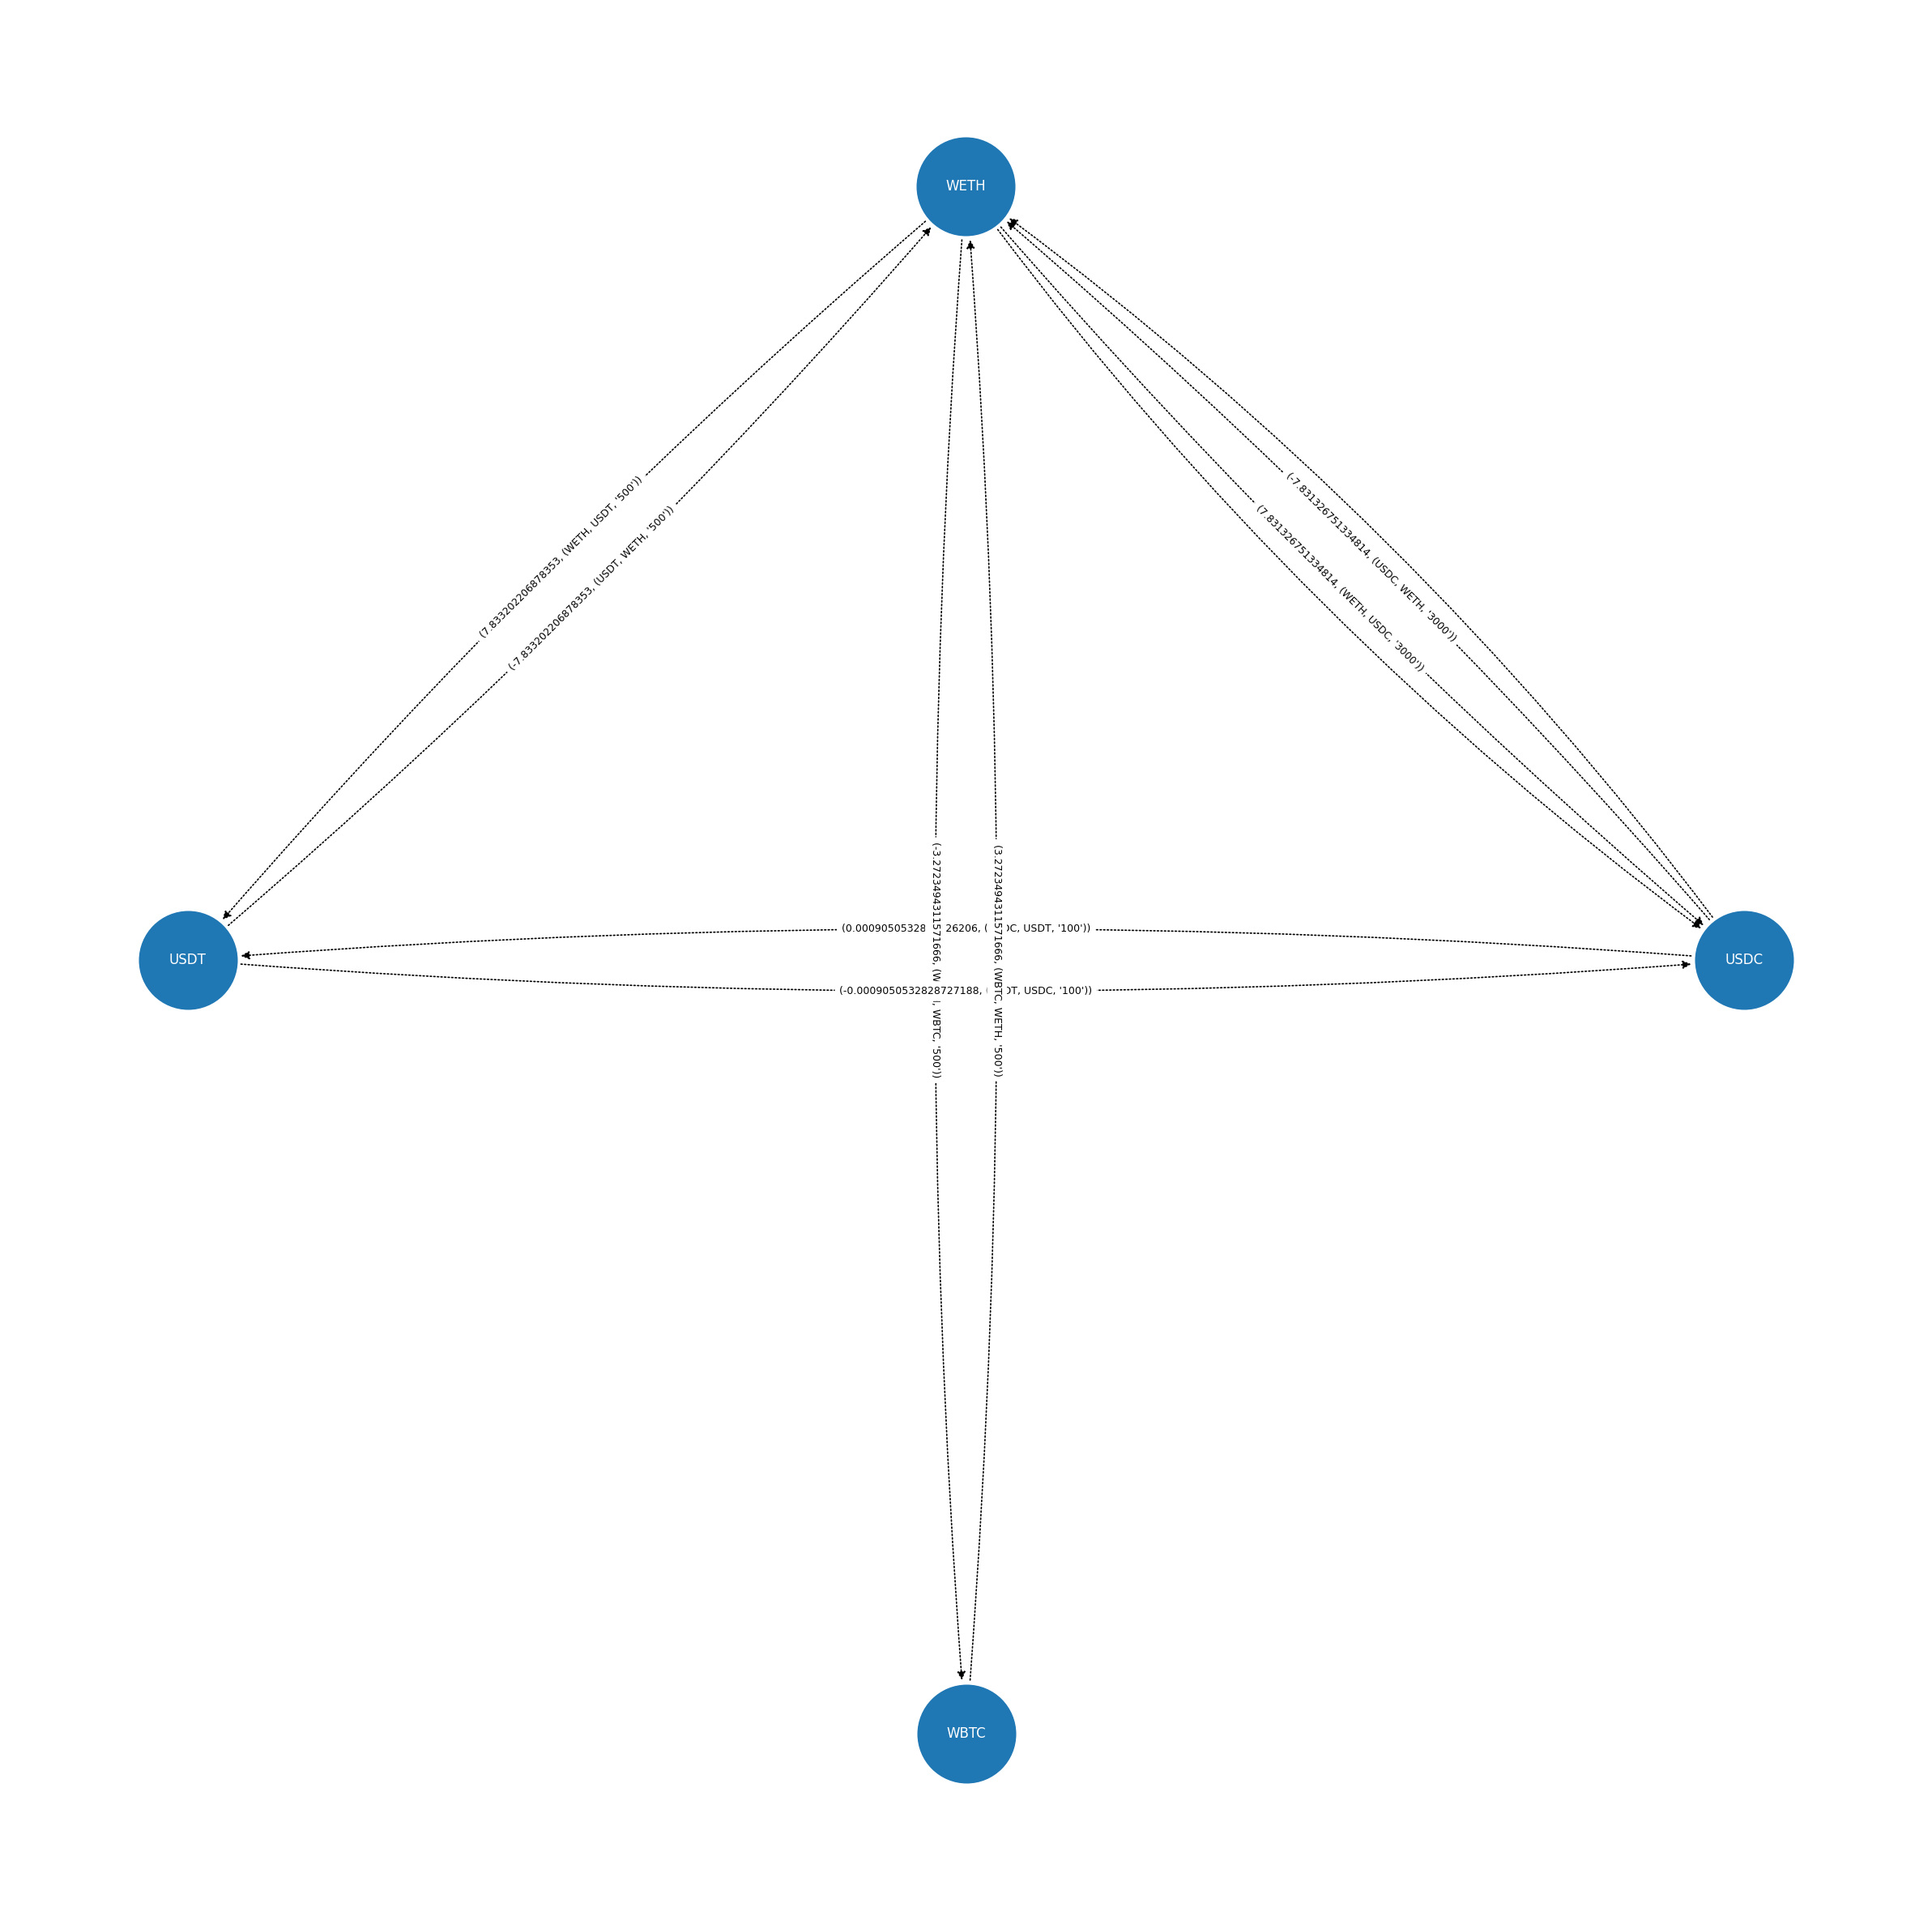

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

G = nx.MultiDiGraph()
print(edges)
print(g.vertices)
G.add_weighted_edges_from(edges)
plt.figure(3, figsize=(10, 10), dpi=300)

pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, node_color="tab:blue", node_size=800)
connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.04] * 4)]
nx.draw_networkx_edges(G, pos, edge_color="black", width=.4, connectionstyle=connectionstyle, min_source_margin=5, min_target_margin=5, style='dotted', arrowsize=5, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif", font_color="white")
nx.draw_networkx_edge_labels(G,pos, font_size=3, connectionstyle=connectionstyle, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

plt.axis("off")
plt.show()

In [9]:
weth = g[Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))][0][0]
usdc = g[Vertex("WETH", 18, Web3.to_checksum_address("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))][0][1]

In [10]:
g[weth]

[([WETH, USDC, (7.832425629907495, (WETH, USDC, '500'))]),
 ([WETH, USDT, (7.833202206878353, (WETH, USDT, '500'))]),
 ([WETH, USDC, (7.831326751334814, (WETH, USDC, '3000'))]),
 ([WETH, WBTC, (-3.2723494311571666, (WETH, WBTC, '500'))])]

In [11]:
g[usdc]

[([USDC, WETH, (-7.832425629907495, (USDC, WETH, '500'))]),
 ([USDC, USDT, (0.0009050532828726206, (USDC, USDT, '100'))]),
 ([USDC, WETH, (-7.831326751334814, (USDC, WETH, '3000'))])]